
# 📈 Portfolio Analysis

This notebook loads a **portfolio** (ticker + quantity), fetches historical prices from **Alpha Vantage**, 
computes **daily portfolio value**, and compares it to a **benchmark** (BOVA11.SAO as IBOV proxy).

### Goal:
- Robust data fetching with **API key from .env**, retries, and simple **local caching**
- Clean alignment of trading calendars and closing prices
- Clear plots for benchmark vs. portfolio


In [1]:
import os
from dotenv import load_dotenv
from alpha_vantage.timeseries import TimeSeries
from datetime import date, timedelta
import pandas as pd

# Load variables from .env file
load_dotenv()

# Get the API key securely
api_key = os.getenv("ALPHAVANTAGE_API_KEY")
ts = TimeSeries(key=api_key, output_format='pandas')

In [2]:
portfolio = pd.read_excel('portfolio.xlsx')
display(portfolio)

,Ativos,Início
0,ITUB4,10000
1,ABEV3,10000
2,VALE3,10000
3,BBDC3,10000


In [3]:
# Search for the stock symbol
print('Searching for STOCKS')
print(ts.get_symbol_search('itub'))

# Get daily adjusted data for the stock
data, meta_data = ts.get_daily(symbol='ITUB4.SAO', outputsize='full')
display(data)

Searching for STOCKS
(                                1. symbol  \
date                                        
1970-01-01 00:00:00.000000000        ITUB   
1970-01-01 00:00:00.000000001  ITUB3F.SAO   
1970-01-01 00:00:00.000000002  ITUB4F.SAO   
1970-01-01 00:00:00.000000003      ITUBCK   
1970-01-01 00:00:00.000000004   ITUB3.SAO   
1970-01-01 00:00:00.000000005   ITUB4.SAO   

                                                                         2. name  \
date                                                                               
1970-01-01 00:00:00.000000000                         Itau Unibanco Holding S.A.   
1970-01-01 00:00:00.000000001                                             ITUB3F   
1970-01-01 00:00:00.000000002                                             ITUB4F   
1970-01-01 00:00:00.000000003  Turnaround Strategy Portfolio 20234 Invesco Un...   
1970-01-01 00:00:00.000000004                         Itaú Unibanco Holding S.A.   
1970-01-01 00:00:00.000000005

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-09-30,39.0700,39.0700,39.0700,39.0700,32271800.0
2025-09-29,39.0800,39.3600,38.8600,38.8900,18567400.0
2025-09-26,38.5400,38.8600,38.4900,38.6700,12414500.0
2025-09-25,38.8100,39.0200,38.4700,38.4800,14705600.0
2025-09-24,39.0600,39.1400,38.7100,38.7900,18168400.0
...,...,...,...,...,...
2005-01-07,393.0208,397.9968,391.0083,393.4993,129146796.0
2005-01-06,393.9976,399.0132,391.1010,393.9976,372692145.0
2005-01-05,397.9968,400.9995,395.0008,399.0000,863768854.0


In [4]:
stock_data = {}
end_date = pd.Timestamp(date.today() - timedelta(days=1))
start_date = pd.Timestamp('2021-01-05')

# Fetch data for each stock in the portfolio
for stock in portfolio['Ativos']:
    print(f'Fetching data for {stock}')
    data, meta_data = ts.get_daily(symbol=f'{stock}.SAO', outputsize='full')
    stock_data[stock] = data
    
    portfolio.loc[portfolio['Ativos'] == stock, 'Qntd'] = portfolio.loc[portfolio['Ativos'] == stock, 'Início'].values / data.loc[start_date, '4. close']


Fetching data for ITUB4
Fetching data for ABEV3
Fetching data for VALE3
Fetching data for BBDC3


In [5]:
display(portfolio)
display(stock_data['ITUB4'])

,Ativos,Início,Qntd
0,ITUB4,10000,325.732899
1,ABEV3,10000,632.511069
2,VALE3,10000,107.526882
3,BBDC3,10000,426.075841


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-09-30,39.0700,39.0700,39.0700,39.0700,32271800.0
2025-09-29,39.0800,39.3600,38.8600,38.8900,18567400.0
2025-09-26,38.5400,38.8600,38.4900,38.6700,12414500.0
2025-09-25,38.8100,39.0200,38.4700,38.4800,14705600.0
2025-09-24,39.0600,39.1400,38.7100,38.7900,18168400.0
...,...,...,...,...,...
2005-01-07,393.0208,397.9968,391.0083,393.4993,129146796.0
2005-01-06,393.9976,399.0132,391.1010,393.9976,372692145.0
2005-01-05,397.9968,400.9995,395.0008,399.0000,863768854.0


In [6]:
# Get IBOV data
ibov, meta_data = ts.get_daily(symbol='BOVA11.SAO', outputsize='full')
ibov.head()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2025-09-30,144.11,144.55,142.84,143.24,3469293.0
2025-09-29,144.21,144.64,143.25,143.45,4049167.0
2025-09-26,142.60,143.26,142.11,142.44,2944933.0
2025-09-25,143.24,143.49,142.20,142.28,5367085.0
2025-09-24,143.50,143.78,143.05,143.42,2322354.0


In [7]:
# Sort IBOV data
ibov = ibov.copy()
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.sort_index()
display(ibov)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2008-12-02,35.11,35.81,34.91,35.39,759942.0
2008-12-03,34.73,35.40,33.90,35.31,330158.0
2008-12-04,35.80,36.00,35.15,35.70,128400.0
2008-12-05,34.51,35.35,34.11,35.35,193700.0
2008-12-08,37.35,38.46,36.95,38.46,103100.0
...,...,...,...,...,...
2025-09-24,143.50,143.78,143.05,143.42,2322354.0
2025-09-25,143.24,143.49,142.20,142.28,5367085.0
2025-09-26,142.60,143.26,142.11,142.44,2944933.0


In [8]:
# Filter IBOV data for the specified date range
ibov = ibov.loc[start_date:end_date, '4. close']
display(ibov)

date
2021-01-05    114.69
2021-01-06    114.55
2021-01-07    118.37
2021-01-08    120.40
2021-01-11    118.62
               ...  
2025-09-24    143.42
2025-09-25    142.28
2025-09-26    142.44
2025-09-29    143.45
2025-09-30    143.24
Name: 4. close, Length: 1187, dtype: float64

<Axes: title={'center': 'IBOV Closing Prices'}, xlabel='date'>

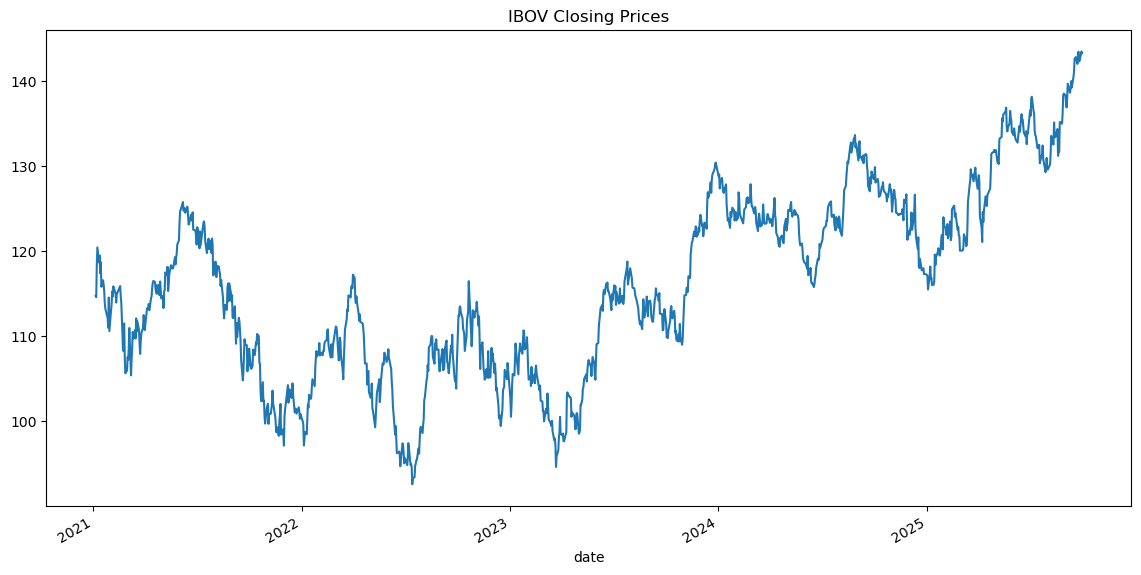

In [9]:
ibov.plot(title='IBOV Closing Prices', figsize=(14, 7))

In [10]:
# Prepare a DataFrame to hold closing prices of all stocks in the portfolio
stock_closed_prices = pd.DataFrame()

for stock in stock_data:
    stock_data[stock].index = pd.to_datetime(stock_data[stock].index)
    stock_data[stock] = stock_data[stock].sort_index()
    stock_closed_prices[stock] = stock_data[stock].loc[start_date:end_date, '4. close']
    
stock_closed_prices

,ITUB4,ABEV3,VALE3,BBDC3
date,,,,
2021-01-05,30.7000,15.81,93.00,23.47
2021-01-06,31.6000,16.05,96.05,24.06
2021-01-07,32.8301,16.05,102.32,24.65
2021-01-08,32.8200,16.53,102.00,24.46
2021-01-11,32.0800,16.10,101.98,24.09
...,...,...,...,...
2025-09-24,38.7900,12.38,57.89,15.17
2025-09-25,38.4800,12.46,58.21,15.01
2025-09-26,38.6700,12.46,57.09,15.09


<Axes: title={'center': 'Stock Closing Prices'}, xlabel='date'>

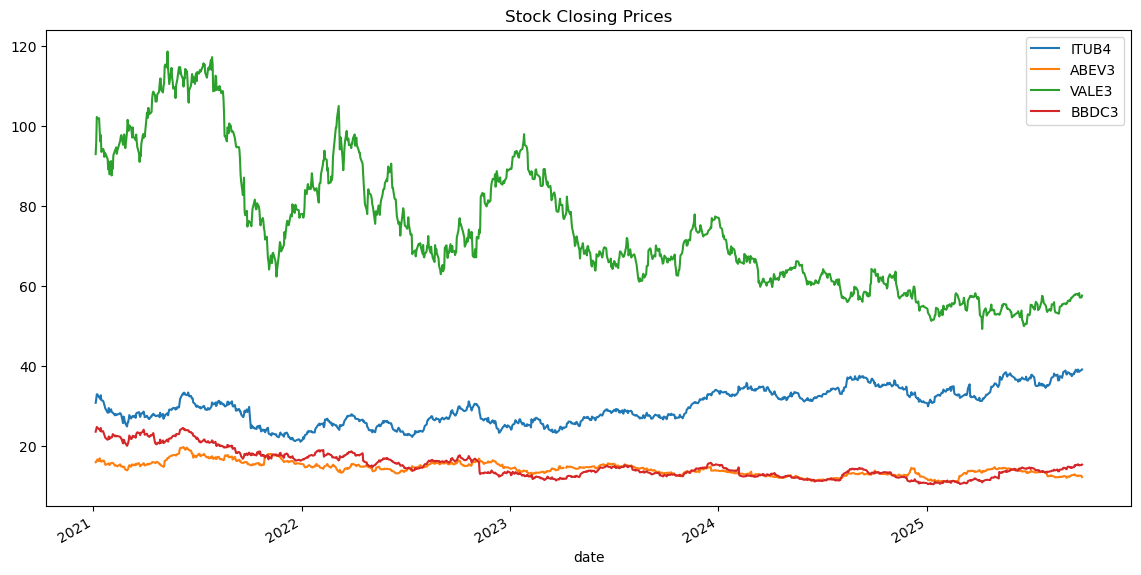

In [11]:
# Plot Stock Prices
stock_closed_prices.plot(title='Stock Closing Prices', figsize=(14, 7))

In [12]:
# Calculate the portfolio value over time
portfolio_value = pd.DataFrame()

for stock in stock_closed_prices.columns:
    # multiply each stock’s daily close price by its quantity
    qty = portfolio.loc[portfolio['Ativos'] == stock, 'Qntd'].values[0]
    portfolio_value[stock] = stock_closed_prices[stock] * qty

portfolio_value['Total'] = portfolio_value.sum(axis=1)

display(portfolio)
display(portfolio_value)

,Ativos,Início,Qntd
0,ITUB4,10000,325.732899
1,ABEV3,10000,632.511069
2,VALE3,10000,107.526882
3,BBDC3,10000,426.075841


,ITUB4,ABEV3,VALE3,BBDC3,Total
date,,,,,
2021-01-05,10000.000000,10000.000000,10000.000000,10000.000000,40000.000000
2021-01-06,10293.159609,10151.802657,10327.956989,10251.384746,41024.304001
2021-01-07,10693.843648,10151.802657,11002.150538,10502.769493,42350.566335
2021-01-08,10690.553746,10455.407970,10967.741935,10421.815083,42535.518734
2021-01-11,10449.511401,10183.428210,10965.591398,10264.167022,41862.698030
...,...,...,...,...,...
2025-09-24,12635.179153,7830.487034,6224.731183,6463.570516,33153.967885
2025-09-25,12534.201954,7881.087919,6259.139785,6395.398381,33069.828039
2025-09-26,12596.091205,7881.087919,6138.709677,6429.484448,33045.373250


<Axes: title={'center': 'Portfolio Total Value Over Time'}, xlabel='date'>

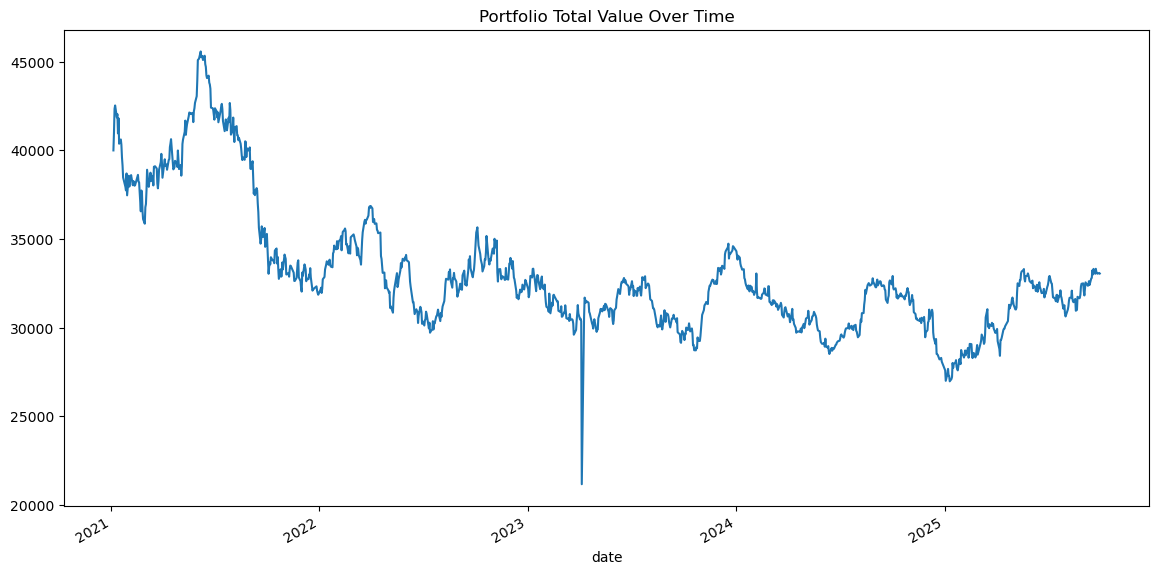

In [13]:
# Plot Portfolio Value
portfolio_value['Total'].plot(title='Portfolio Total Value Over Time', figsize=(14, 7))

In [14]:
# Portfolio Performance
total_initial_investment = portfolio_value['Total'].iloc[0]
portfolio_value['Performance'] = (portfolio_value['Total'] - total_initial_investment) / total_initial_investment * 100
display(portfolio_value)

# IBOV Performance
ibov_initial = ibov.iloc[0]
ibov_performance = (ibov - ibov_initial) / ibov_initial * 100
display(ibov_performance) 


,ITUB4,ABEV3,VALE3,BBDC3,Total,Performance
date,,,,,,
2021-01-05,10000.000000,10000.000000,10000.000000,10000.000000,40000.000000,0.000000
2021-01-06,10293.159609,10151.802657,10327.956989,10251.384746,41024.304001,2.560760
2021-01-07,10693.843648,10151.802657,11002.150538,10502.769493,42350.566335,5.876416
2021-01-08,10690.553746,10455.407970,10967.741935,10421.815083,42535.518734,6.338797
2021-01-11,10449.511401,10183.428210,10965.591398,10264.167022,41862.698030,4.656745
...,...,...,...,...,...,...
2025-09-24,12635.179153,7830.487034,6224.731183,6463.570516,33153.967885,-17.115080
2025-09-25,12534.201954,7881.087919,6259.139785,6395.398381,33069.828039,-17.325430
2025-09-26,12596.091205,7881.087919,6138.709677,6429.484448,33045.373250,-17.386567


date
2021-01-05     0.000000
2021-01-06    -0.122068
2021-01-07     3.208649
2021-01-08     4.978638
2021-01-11     3.426628
                ...    
2025-09-24    25.050135
2025-09-25    24.056151
2025-09-26    24.195658
2025-09-29    25.076293
2025-09-30    24.893190
Name: 4. close, Length: 1187, dtype: float64

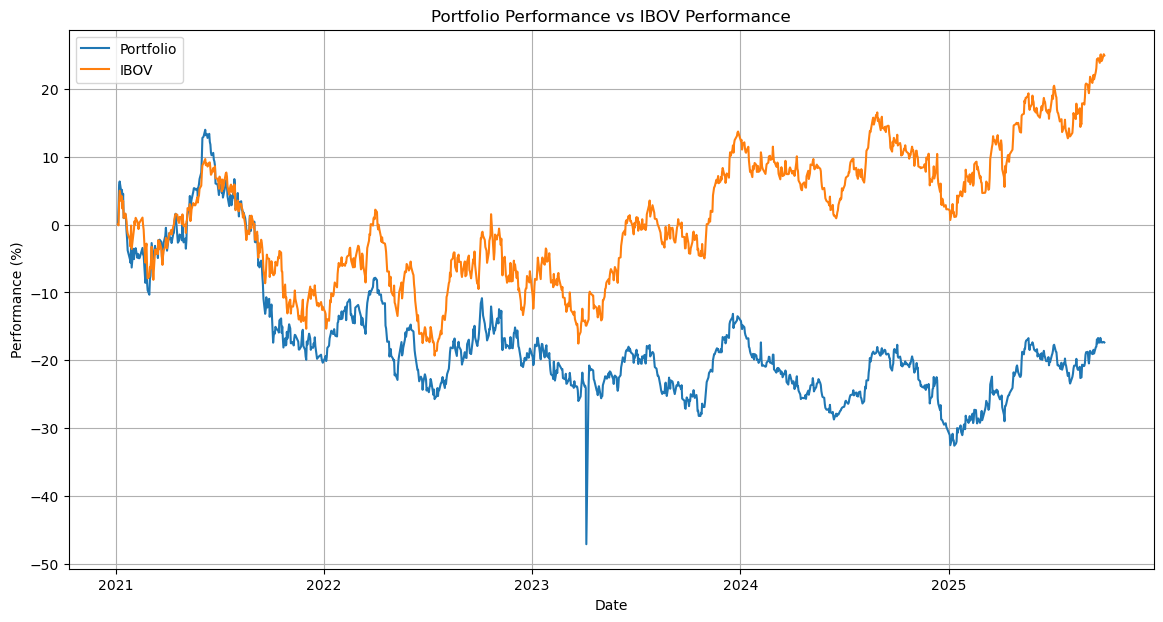

In [15]:
# Plot Portfolio Performance vs IBOV Performance
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(portfolio_value.index, portfolio_value['Performance'], label='Portfolio')
plt.plot(ibov_performance.index, ibov_performance, label='IBOV')
plt.title('Portfolio Performance vs IBOV Performance')
plt.xlabel('Date')
plt.ylabel('Performance (%)')
plt.legend()
plt.grid()
plt.show()